In [13]:
import numpy as np
import cupy as cp
from matplotlib import pyplot as plt
from tqdm import tqdm
import h5py as hp

In [14]:
from matplotlib import rc
from matplotlib import gridspec

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

In [15]:
xp = cp
print(xp.__name__)
cp.__version__

cupy


'10.3.0'

In [16]:
hbar = 1
m = 1

x_max = 20
Nx = 1000
Neng = 100
dx = 2.0 * x_max / Nx
hbar_inv = 1.0 / hbar

x = xp.linspace(-x_max, x_max, Nx)
E = xp.linspace(0.1, 3, Neng)

In [17]:
def potential(x):
    x2 = x**2
    V = (x2 / 2.0 - 0.8) * xp.exp(-0.1 * x2)
    return V

In [24]:
def potential(x):
    if np.abs(x) < 3:
        V = 2
    else:
        V = 0
    return V

potential = np.vectorize(potential)

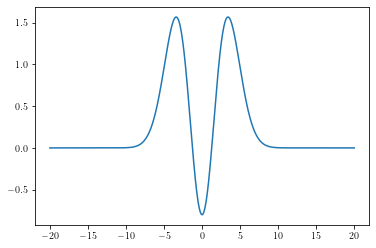

In [19]:
%matplotlib inline
plt.plot(cp.asnumpy(x), cp.asnumpy(potential(x)))

In [20]:
def propagator(psi, x, eng, typ="back"):
    cf = 2.0 * (1.0 - m * dx**2 * hbar_inv**2 * (eng - potential(x)))
    psi_new = cp.asarray(psi.copy())
    
    if typ=="back":
        assert psi[-1] != 0 and psi[-2] != 0
        for n in reversed(range(0, len(psi)-2)):
            psi_new[n] =  cf[n+1] * psi_new[n+1] - psi_new[n+2]
    
    elif typ=="forward":
        assert psi[0] != 0 and psi[1] != 0
        for n in range(2, len(psi)-2):
            psi_new[n] = cf[n-1] * psi_new[n-1] - psi_new[n-2]
    
    else:
        pass

    return psi_new


def propagator2(psi1, psi2, x, E, typ="back", store_psi=True): 
    if store_psi:        
        pth = "./dat_X/"
        
        xp.save(pth+"file_psi_{:.5f}".format(float(x[-1])), xp.append(float(x[-1]),psi2))
        xp.save(pth+"file_psi_{:.5f}".format(float(x[-2])), xp.append(float(x[-2]),psi1))
        xp.save(pth+"coordinates", x)
        xp.save(pth+"energies", E)
    
    
    if typ=="back":
        for xn in tqdm(list(reversed(x[0:-1]))):
            cf1 = 2.0 * (1.0 - m * dx**2 * hbar_inv**2 * (E - potential(xn)))
            psi0 = cf1 * psi1 - psi2
            psi2 = psi1
            psi1 = psi0
            
            if store_psi:# and xn > -10 and xn < 10:
                xp.save(pth+"file_psi_{:.5f}".format(float(xn)), xp.append(xn,psi0))
                
    else:
        pass
                            
    
    return psi1, psi2

def propagator3(psi1, psi2, x, E, typ="back", store_psi=True): 
    if store_psi:
        pth = "./dat_1/"
        with hp.File(pth+"saved_data3.h5",'a') as sfile:
            dataset = sfile.create_dataset("data", data=cp.asnumpy(xp.column_stack((xp.append(x[-1],psi2),xp.append(x[-2],psi1)))),#
                                           maxshape=(psi1.shape[0]+1,None), compression='gzip',chunks=True)

            sfile.create_dataset("ENG",data=cp.asnumpy(E))
            sfile.create_dataset("POS",data=cp.asnumpy(x))
        
        
        # sfile = hp.File(pth+"saved_data1.h5",'a')
        # dataset = sfile.get('data')
            
            exmp = xp.append(x[-1], psi2)
            counter = 0
            #buff= xp.append(x[-2],psi1)
            buff= xp.zeros_like(exmp)
            chunk = 50
                                                                   
            if typ=="back":
                for xn in tqdm(list(reversed(x[0:-1]))):
                    cf1 = 2.0 * (1.0 - m * dx**2 * hbar_inv**2 * (E - potential(xn)))
                    psi0 = cf1 * psi1 - psi2
                    psi2 = psi1
                    psi1 = psi0
                    
                    buff = xp.column_stack((buff, xp.append(xn,psi1)))
                    counter += 1

                    if counter == chunk or xn == x[0]:
                        #print("saving now")
                        dataset.resize(dataset.shape[1] + counter, axis=1)
                        dataset[:,-counter:] = cp.asnumpy(buff[:,1:])
                        buff = xp.zeros_like(exmp)
                        counter = 0
                            
    else:
        pass
    
    return psi1, psi2


def get_coeff(psi, x, eng):
    k = hbar_inv * xp.sqrt(2 * m * eng)
    exponents = xp.array(list(map(lambda n: xp.array([k * x[n] * 1.0j, -k * x[n] * 1.0j]), [0, 1] )))
    mat = xp.exp(exponents)
    
    A, B = xp.dot(xp.linalg.inv(mat), psi[0:2])
    T = 1.0 / A
    R = B * T
    return R, T

def get_coeff2(psi0, psi1, x, eng):
    K = hbar_inv * xp.sqrt(2 * m * E)
    exponents = xp.array(list(map(lambda n: xp.array([K * x[n] * 1.0j, -K * x[n] * 1.0j]), [0, 1] )))
    mat = xp.exp(exponents)

    ab = list()
    for n in range(0, mat.shape[2]):
        ab.append(xp.dot(xp.linalg.inv(mat[:,:,n]), xp.array([psi00[n], psi01[n]])))
    ab = xp.array(ab)
    aa, bb = ab.T

    T = 1.0 / aa
    R = T * bb
    
    return R, T

In [10]:
# version 1 - by energy
psi = cp.zeros_like(x, dtype=complex)
#eng = 0.5

k = lambda e: hbar_inv * cp.sqrt(2 * m * e)

T12 = list()

for eng in E:
    if eng == 0: 
        T2.append(0)
        continue
        
    psi = cp.zeros_like(x, dtype=complex)
    
    psi[-1] = cp.exp(k(eng) * x[-1] * 1.0j)
    psi[-2] = psi[-1] - ddx * dx
    
    newpsi = propagator(psi, x, eng)
    R1, T1 = get_coeff(newpsi, x, eng)
    T12.append(cp.abs(T1)**2)

In [13]:
# version 2 - vectorized
#E=np.array([0.1,1,2])

k = lambda e: hbar_inv * xp.sqrt(2 * m * e)
psi2 = xp.exp(k(E) * x[-1] * 1.0j)
psi1 = xp.exp(k(E) * x[-2] * 1.0j)

psi00, psi01 = propagator2(psi1, psi2, x, E, store_psi=True)
R, T = get_coeff2(psi00, psi01, x, E)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 452.03it/s]


In [ ]:
with hp.File("./dat_4/saved_data1.h5",'r') as file:
    data = file.get('data')
    eng = file.get('./dat_4/ENG')
    posx = file.get('./dat_4/POS')
    idx = np.where(np.array(posx) > 3)[0][0]
    
    dd = np.array(data)
    sele = dd[1:, idx]
    #plt.plot(np.array(eng), np.array(data)[1:, idx] )
    
    
    #print(data[-1,:])

In [24]:
psi00.dtype

dtype('complex128')

In [18]:
xp.append(0,psi1).T.shape

(401,)

In [154]:
np.abs(T)**2 + np.abs(R)**2

array([1., 1., 1., ..., 1., 1., 1.])

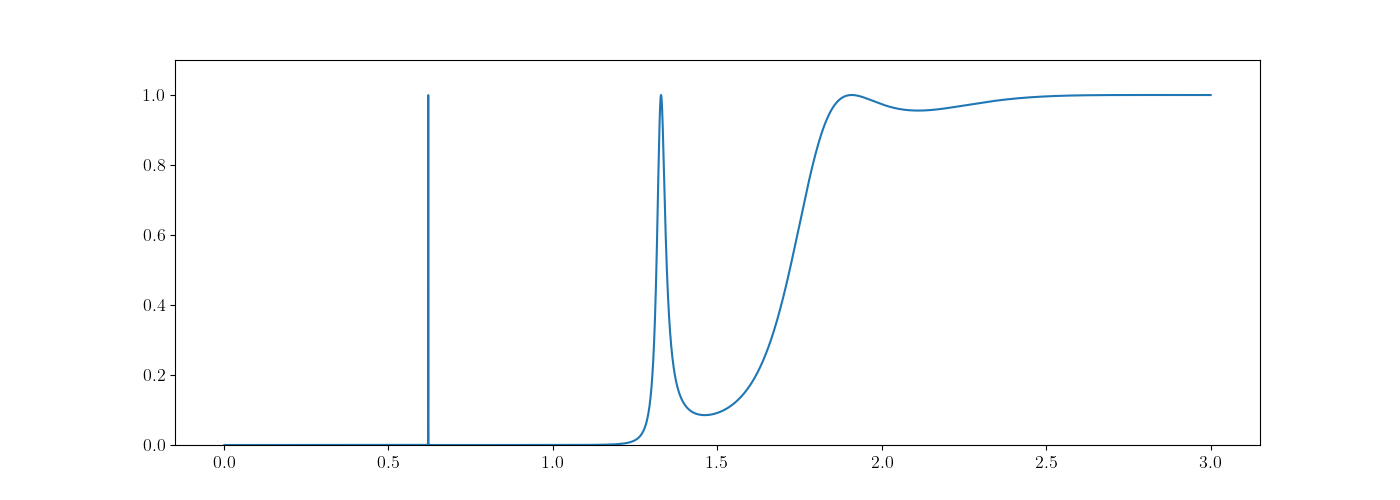

In [199]:
plt.figure(figsize=(14,5))
plt.ylim(0,1.1)
plt.plot(cp.asnumpy(E), cp.asnumpy(cp.abs(T)**2))

In [174]:
cp.save("./dat_3/"+"data_{:.3f}".format(23.76),E)

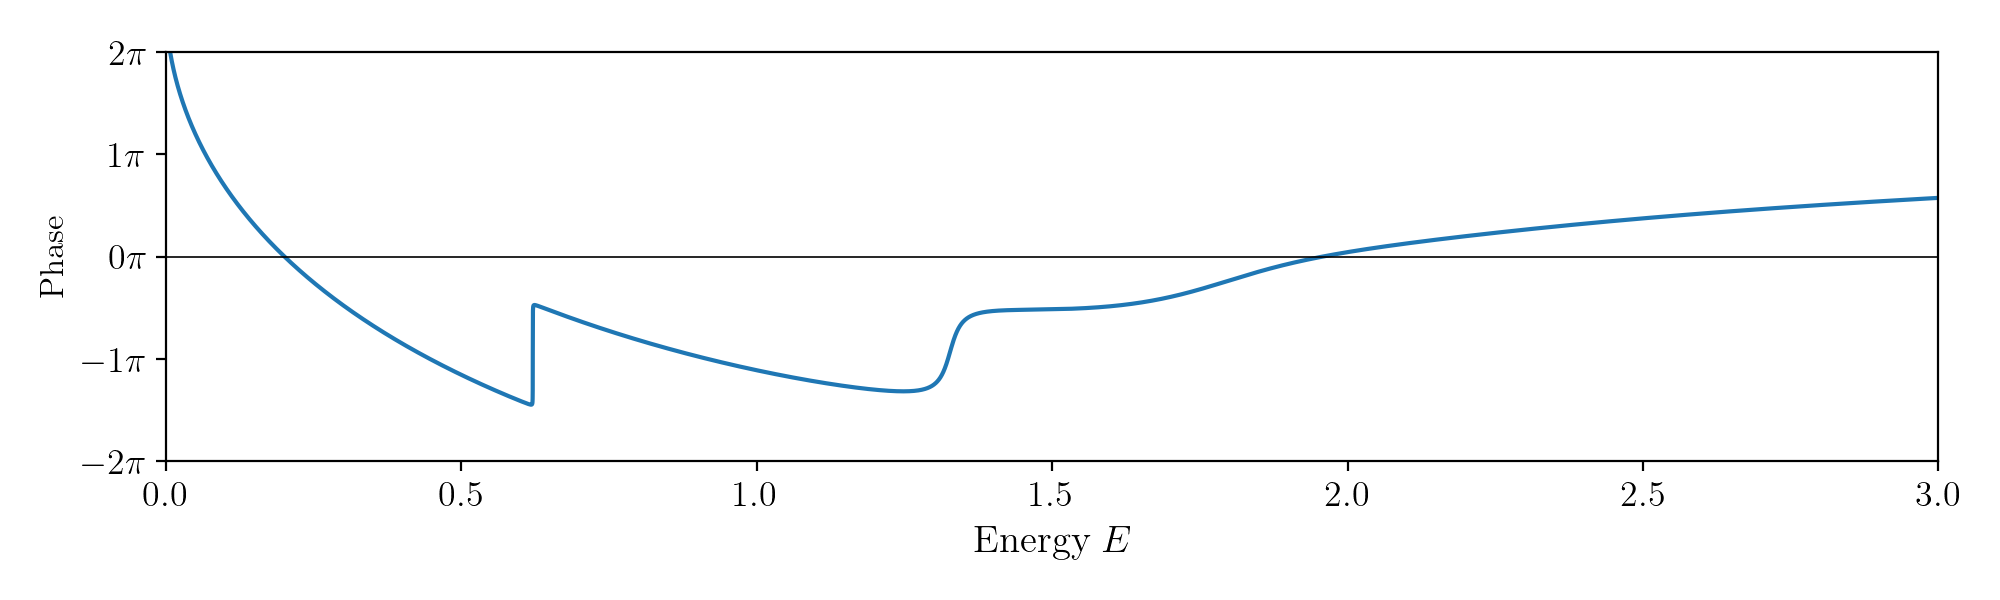

In [81]:
import matplotlib.ticker as tck

f,ax=plt.subplots(figsize=(10,3),dpi=200)
plt.xlim(0,3)
plt.ylim(-2,2)
ax.yaxis.set_major_formatter(tck.FormatStrFormatter('$%g \pi$'))
ax.yaxis.set_major_locator(tck.MultipleLocator(base=1))

ptt = xp.imag(xp.log(T))
pttc = xp.unwrap(ptt) / xp.pi + 2

plt.plot(xp.asnumpy(E), xp.asnumpy(pttc))
plt.plot([0,3],[0,0],color='k',linewidth=0.6)

plt.xlabel("$\mathrm{Energy}\ E$",size=14)
plt.ylabel("$\mathrm{Phase}$",size=12)
plt.tight_layout()
plt.show()

C:\Users\micha\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


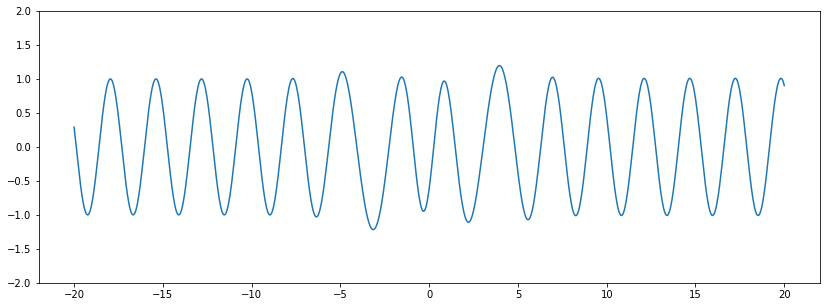

In [51]:
plt.figure(figsize=(14,5))
plt.ylim(-2,2)
plt.plot(x, psi[:,-3])

In [85]:
iii = np.nonzero(np.where(E > 1.0, E, 0))[0][0]
#np.nonzero(np.where(np.abs(T)**2 > 0.99999999, np.abs(T)**2, 0 ))
#ei = np.sort(np.where(np.abs(T)**2 > 0.99, E, 0 )[0:ii-1])[-1]
ei = 0.6210902527256319

In [86]:
index1 = np.nonzero(np.where(np.load("./dat_2/energies.data.npy") == ei, 1, 0))[0][0]
index1

81751

In [91]:
#index1 = 
np.nonzero(np.where(ydata >= ei, 1, 0))[0][0]
#index1

819

In [79]:
ddd = np.load("./dat_2/file_psi_-20.00000.data.npy")
ddd[0], list(zip(E,ddd))[index]

((-20+0j), (0.6210902527256319, (0.9825943777919328-0.41719692676733444j)))

In [8]:
import os
directory = "./dat_2/"

psi_data = np.array([0,0])

for filename in os.listdir(directory):
    if "file" in filename:
        data = np.load(directory+filename)
        psi_data = np.vstack([psi_data,[data[0],data[index+1]]])

In [99]:
psi_data[psi_data[0:10,0].argsort()]

array([[-3.40034003e-02+0.j        , -5.01185183e+00+0.2968949j ],
       [-3.00030003e-02+0.j        , -4.48497837e+00+0.26479407j],
       [-2.60026003e-02+0.j        , -3.95790105e+00+0.23268121j],
       [-2.20022002e-02+0.j        , -3.43064381e+00+0.20055776j],
       [-1.80018002e-02+0.j        , -2.90323061e+00+0.1684252j ],
       [-1.40014001e-02+0.j        , -2.37568541e+00+0.13628499j],
       [-1.00010001e-02+0.j        , -1.84803219e+00+0.10413857j],
       [-6.00060006e-03+0.j        , -1.32029494e+00+0.07198742j],
       [-2.00020002e-03+0.j        , -7.92497649e-01+0.039833j  ],
       [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ]])

In [9]:
psd = psi_data[1:]
psdT = psd[psd[:,0].argsort()].T
psdT

array([[-20.        +0.j        , -19.9959996 +0.j        ,
        -19.9919992 +0.j        , ...,  19.9919992 +0.j        ,
         19.9959996 +0.j        ,  20.        +0.j        ],
       [  0.89140188-0.41171504j,   0.89346017-0.40766397j,
          0.89550069-0.4036048j , ...,  -0.9593501 -0.28221874j,
         -0.95808226-0.28649325j,  -0.9554895 -0.2950251j ]])

In [95]:
xp = np

In [ ]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-20,20)
ax.set_ylim(0,3)
ax.set_zlim(-10,10)
#ax.plot(psdT[0],[ei]*len(psdT[0]),psdT[1])

import os
directory = "./dat_3/"

energies = xp.load(directory+"energies.data.npy")
posi = np.load(directory+"coordinates.data.npy")
pos = np.array([posi[0],])

for i in posi:
    if i > pos[-1]+0.1:
        pos = np.append(pos, i)

pos = xp.array(pos)

zdata = xp.array([0]*len(pos))
ydata = xp.array([0])
print(ydata)

for cnt, energ in tqdm(enumerate(energies)):
    # if cnt%100 == 0:
    #     pass
    # else:
    #     continue
        
    psi_data = xp.array([0,0])

    for d in pos:
        data = xp.load(directory+"file_psi_{:.5f}.data.npy".format(float(d)))
        psi_data = xp.vstack([psi_data,[data[0],data[cnt+1]]])
    
    psi_data2 = psi_data[1:]
    psi_data2T = psi_data2[psi_data2[:,0].argsort()].T
    #ax.plot(np.real(psi_data2T[0]), [energ]*len(psi_data2T[0]), np.real(psi_data2T[1]))
    export = psi_data2T[1] / xp.max(np.abs(psi_data2T[1]))
    zdata = xp.vstack([zdata, xp.imag(export)])
    # zdata = np.vstack([zdata, np.real(psi_data2T[1])])
    ydata = np.append(ydata, energ)
    
    #ax.plot(np.real(psi_data2T[0]), [energ]*len(psi_data2T[0]), np.real(psi_data2T[1]))

x, y = xp.meshgrid(pos, ydata)
ax.plot_surface(x, y, zdata, cmap="viridis")
plt.show()

[0]


4349it [1:43:26,  1.61s/it]

In [66]:
pos.shape, ydata.shape, zdata.shape

((400,), (4001,), (4001, 400))

In [91]:
pos.shape, ydataX.shape, zdataX.shape

((400,), (4003,), (4003, 400))

In [83]:
iii = xp.nonzero(xp.where(E > 1.0, E, 0))[0][0]
print(iii)
ei = 0.6210902527256319
index1 = xp.nonzero(xp.where(xp.load("./dat_2/energies.data.npy")[:iii] == ei, 1, 0))[0][0]
print(index1)

199840
81751


In [84]:
id1 = xp.nonzero(xp.where(E > 1.0, E, 0))[0][0]
id2 = xp.nonzero(xp.where(E < 1.5, E, 0))[0][-1]
print(id1, id2)
#ei = 0.6210902527256319
temp = xp.load("./dat_2/energies.data.npy")
TT = xp.abs(T)**2
index2 = xp.nonzero(xp.where(TT == xp.max(TT[id1:id2]), 1, 0))[0][0]
eii = temp[index2]
print(index2, eii)

199840 299859
265621 1.995521938804847


In [86]:
# add two resonances - working
import os
directory = "./dat_2/"


zdataX = zdata.copy()
ydataX = ydata.copy()

for ind2,eng2 in zip([index1,index2],[ei, eii]):
    psi_dataX = xp.array([0,0])
    for d in tqdm(pos):
        dataX = xp.load(directory+"file_psi_{:.5f}.data.npy".format(float(d)))
        psi_dataX = xp.vstack([psi_dataX,[dataX[0],dataX[ind2+1]]])

    psi_data2X = psi_dataX[1:]
    psi_data2XT = psi_data2X[psi_data2X[:,0].argsort()].T
    export = psi_data2XT[1] / xp.max(xp.abs(psi_data2XT[1]))
    zdataX = xp.vstack([zdataX, xp.imag(export)])
    #zdataX = np.vstack([zdataX, np.imag(export)])
    ydataX = cp.array(np.append(cp.asnumpy(ydataX), cp.asnumpy(eng2)))
    print(eng2,ind2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 142.91it/s]


0.6210902527256319 81751


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 146.68it/s]

1.995521938804847 265621


In [88]:
yX = xp.sort(ydataX)
zX = zdataX[ydataX.argsort()]

In [89]:
xxx, yyy = xp.meshgrid(pos, yX[1:])

In [90]:
xxx.shape

(4002, 400)

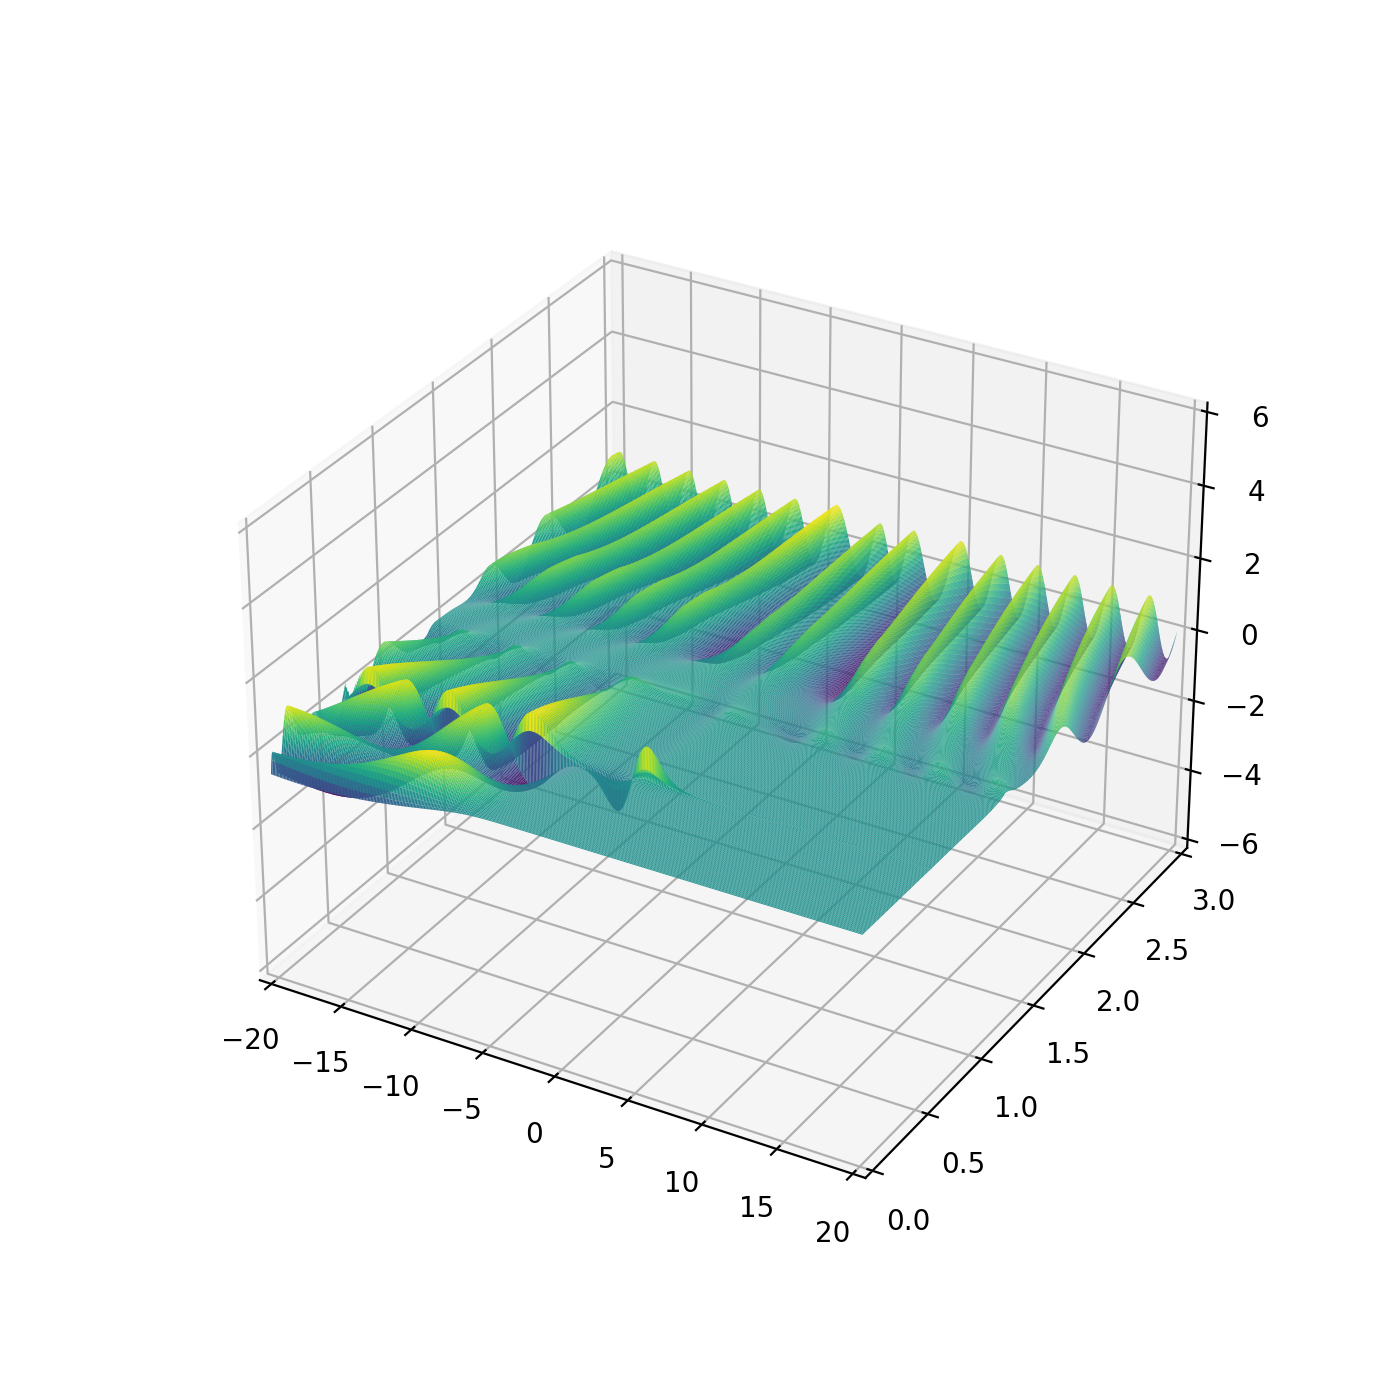

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from matplotlib import gridspec

rc('text', usetex=False)

fig = plt.figure(figsize=(7,7),dpi=200)
axX = fig.add_subplot(111, projection='3d')
axX.set_xlim(-20,20)
axX.set_ylim(0,3)
axX.set_zlim(-6,6)

xxx, yyy = np.meshgrid(pos, yX[1:])
axX.plot_surface(xxx, yyy, zX[1:], cmap="viridis",rstride=10,cstride=1,
                 shade=True,
                 alpha=1,
                 linewidth=0,
                 antialiased=True)
plt.show()

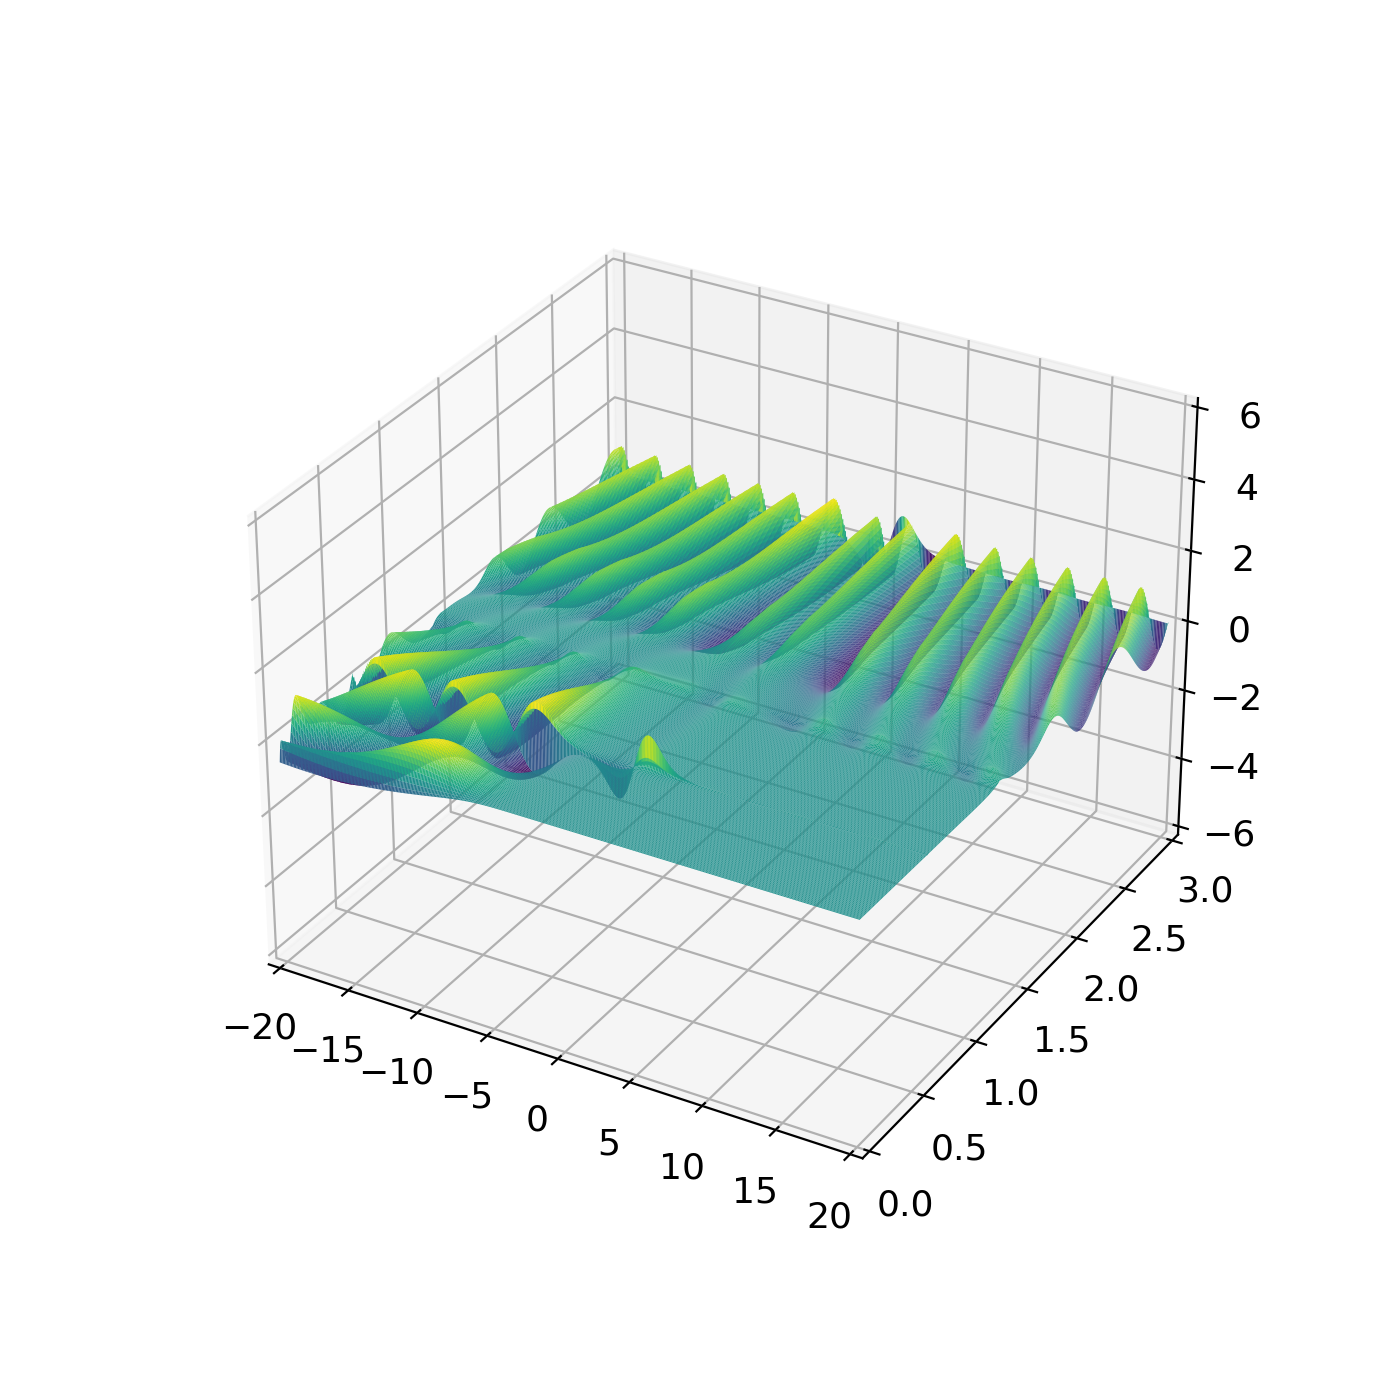

In [148]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

rc('text', usetex=False)

fig = plt.figure(figsize=(7,7),dpi=200)
axX = fig.add_subplot(111, projection='3d')
axX.set_xlim(-20,20)
axX.set_ylim(0,3)
axX.set_zlim(-6,6)

xxx, yyy = np.meshgrid(pos, ydataX[1:])
axX.plot_surface(xxx, yyy, zdataX[1:], cmap="viridis",rstride=10,cstride=1,
                 shade=True,
                 alpha=1,
                 linewidth=0,
                 antialiased=True)
plt.show()

In [135]:
np.set_printoptions(precision=4,suppress=True)

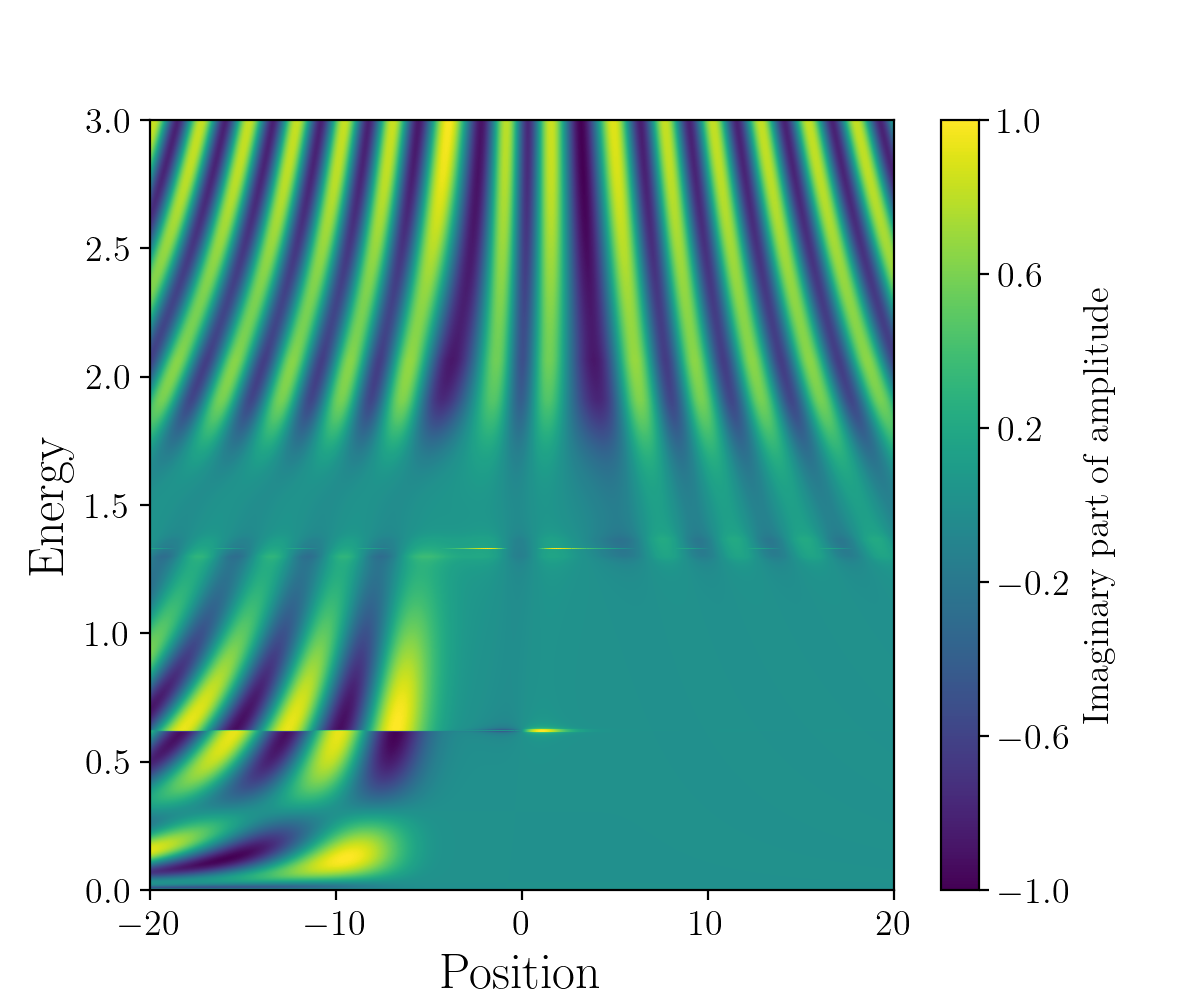

In [61]:
#from scipy.interpolate import griddata
from matplotlib import rc
from matplotlib import gridspec

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

fig = plt.figure(figsize=(6,5),dpi=200)
ax = fig.add_subplot()
ax.set_xlim(-20,20)
ax.set_ylim(0,3)
#ax.set_zlim(-10,10)

x, y = np.meshgrid(pos, yX)
cs = ax.contourf(x, y, zX, 500, cmap="viridis", vmax=1, vmin=-1)
#plt.colorbar(cs, ax=ax, ticks=np.linspace(-1,1,6),label="$\mathrm{Real\ part\ of\ amplitude}$")
plt.colorbar(cs, ax=ax, ticks=np.linspace(-1,1,6),label="$\mathrm{Imaginary\ part\ of\ amplitude}$")
# ax.set_xlabel("Position", fontsize=18)
# ax.set_ylabel("Energy", fontsize=18)
plt.xlabel("$\mathrm{Position}$", fontsize=18)
plt.ylabel("$\mathrm{Energy}$", fontsize=18)
plt.show()



In [26]:
#from scipy.interpolate import griddata
from matplotlib import rc
from matplotlib import gridspec

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=150, facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(ncols=2, nrows=2, height_ratios=[1,9], width_ratios=[25,1], figure=fig) 
print(gs)
ax0 = plt.subplot(gs[2])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[3])

#fig = plt.figure(figsize=(6,5),dpi=200)
ax0.set_xlim(-20,20)
ax0.set_ylim(0,3)

x, y = np.meshgrid(pos, yX)
cs = ax0.contourf(xxx, yyy, zX_img, 500, vmax=1, vmin=-1, cmap="jet",)
#cs = ax0.contourf(xxx, yyy, zX_real, 500, vmax=1, vmin=-1, cmap="jet",)
#plt.colorbar(cs, cax=ax4, ticks=np.linspace(-1,1,6),label="$\mathrm{Real\ part\ of\ amplitude}$")
plt.colorbar(cs, cax=ax4, ticks=np.linspace(-1,1,6),label="$\mathrm{Imaginary\ part\ of\ amplitude}$")
# ax.set_xlabel("Position", fontsize=18)
# ax.set_ylabel("Energy", fontsize=18)

ax1.plot(pos, potential(pos))
ax1.set_ylim(-1.1, 2.1)
ax1.set_yticks([-1, 0, 1, 2])

#plt.setp(ax1.get_yticklabels(), visible=False)
#plt.setp(ax1.get_yticklines(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklines(), visible=False)
ax1.yaxis.tick_right()

plt.subplots_adjust(hspace=.0)

ax0.set_xlabel("$\mathrm{Position}$", fontsize=18)
ax0.set_ylabel("$\mathrm{Energy}$", fontsize=18)
plt.show()

GridSpec(2, 2, height_ratios=[1, 9], width_ratios=[25, 1])


In [27]:
#from scipy.interpolate import griddata
from matplotlib import rc
from matplotlib import gridspec

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=150, facecolor='w', edgecolor='k')

gs = gridspec.GridSpec(ncols=4, nrows=2, height_ratios=[1,8], width_ratios=[3,26,1,1], figure=fig) 
print(gs)
ax3 = plt.subplot(gs[4])
ax0 = plt.subplot(gs[5], sharey = ax3)
ax1 = plt.subplot(gs[1], sharex = ax0)
ax4 = plt.subplot(gs[7])


#fig = plt.figure(figsize=(6,5),dpi=200)
ax0.set_xlim(-20,20)
ax3.set_ylim(0,3)
ax0.set_ylim(0,3)

#x, y = np.meshgrid(pos, yX)
cs = ax0.contourf(xxx, yyy, zX_img, 500, vmax=1, vmin=-1, cmap="jet",)
#cs = ax0.contourf(xxx, yyy, zX_real, 500, vmax=1, vmin=-1, cmap="jet",)
#plt.colorbar(cs, cax=ax4, ticks=np.linspace(-1,1,6),label="$\mathrm{Real\ part\ of\ amplitude}\ \mathrm{Re}[\psi(x)]$")
plt.colorbar(cs, cax=ax4, ticks=np.linspace(-1,1,6),label="$\mathrm{Imaginary\ part\ of\ amplitude}\ \mathrm{Im}[\psi(x)]$")
# ax.set_xlabel("Position", fontsize=18)
# ax.set_ylabel("Energy", fontsize=18)

ax1.plot(pos, potential(pos))
ax1.set_ylim(-1.6, 2.1)
ax1.set_yticks([-1, 0, 1, 2])

ax3.plot(np.abs(T)**2, E)
ax3.set_xlim( 1.1, -0.1)
ax3.set_xticks([0, 1])

plt.setp(ax0.get_yticklabels(), visible=False)
plt.setp(ax0.get_yticklines(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklines(), visible=False)
ax1.yaxis.tick_right()

ax3.xaxis.set_label_position('top')
ax3.xaxis.tick_top()

plt.subplots_adjust(hspace=.0, wspace=0.0)

# place a text box in upper left in axes coords
ax1.text(0.01, 0.9, "$V(x)$", transform=ax1.transAxes, fontsize=14,
        verticalalignment='top')
ax3.text(0.1, 0.01, "$T^2(E)$", transform=ax3.transAxes, fontsize=14, rotation=90,
        verticalalignment='bottom', horizontalalignment='left')


ax0.set_xlabel("$\mathrm{Position}\ x$", fontsize=18)
ax3.set_ylabel("$\mathrm{Energy}\ E$", fontsize=18)
plt.show()

GridSpec(2, 4, height_ratios=[1, 8], width_ratios=[3, 26, 1, 1])


In [86]:
def plot_slices(intervals, typ, **kwargs):
    from matplotlib import rc
    from matplotlib import gridspec
    import numpy as np
    
    if typ == "real":
        func = np.real
        lab = "$\mathrm{Real\ part}$"
    elif typ == "img":
        func = np.imag
        lab = "$\mathrm{Imaginary\ part}$"

    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
    rc('text', usetex=True)
    rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

    fig = plt.figure(figsize=(10,4),dpi=200)
    ax = fig.add_subplot()
    ax.set_xlim(-20,20)
    ax.set_ylim(-1.1, 1.1)
    
    directory = "./Ndat_02/"
    temp = np.load(directory+"energies.npy")
    E = temp
    T = np.load(directory+"T.npy")
    pos = np.load(directory+"coordinates.npy")
    TT = np.abs(T)**2

    for pair in intervals:
        i1, i2 = pair
        id1 = np.nonzero(np.where(E > i1, E, 0))[0][0]
        id2 = np.nonzero(np.where(E < i2, E, 0))[0][-1]

        id01 = np.nonzero(np.where(TT == max(TT[id1:id2]), 1, 0))[0][0]

        eng = temp[id01]
        ps01 = np.array([0,0])
        print(eng)
        #continue

        for d in pos:
            dataX = np.load(directory+"file_psi_{:.5f}.npy".format(d))
            ps01 = np.vstack([ps01, [dataX[0], dataX[id01+1]]])

        ps02 = ps01[1:]
        ps03 = ps02[ps02[:,0].argsort()].T
        export = ps03[1] / np.max(np.abs(ps03[1]))
        p = plt.plot(np.real(ps03[0]), np.real(export), label="$\mathrm{Re},\ $"+"$E={:.3f}$".format(eng), linewidth=1, **kwargs)
        plt.plot(np.real(ps03[0]), np.imag(export), label="$\mathrm{Im},\ $"+"$E={:.3f}$".format(eng), linewidth=1, linestyle="dotted", color=p[-1].get_color(), **kwargs)
        np.save("C:/Users/micha/Downloads/rez_x_{:g}".format(eng),np.real(ps03[0]))
        np.save("C:/Users/micha/Downloads/rez_y_{:g}".format(eng),export)
        
    plt.xlabel("$\mathrm{Position}$", fontsize=18)
    plt.ylabel("$\mathrm{Amplitude}$", fontsize=18)

    plt.plot(pos, [0]*len(pos), [0, 0], [-2, 2], color='k', linewidth=0.2)

    plt.legend(loc='lower center', prop={'size': 13}, frameon=False, bbox_to_anchor=(0.5, 1.05),ncol=len(intervals))
    plt.tight_layout()
    plt.show()

0.6210903346505577
1.3289629179381965


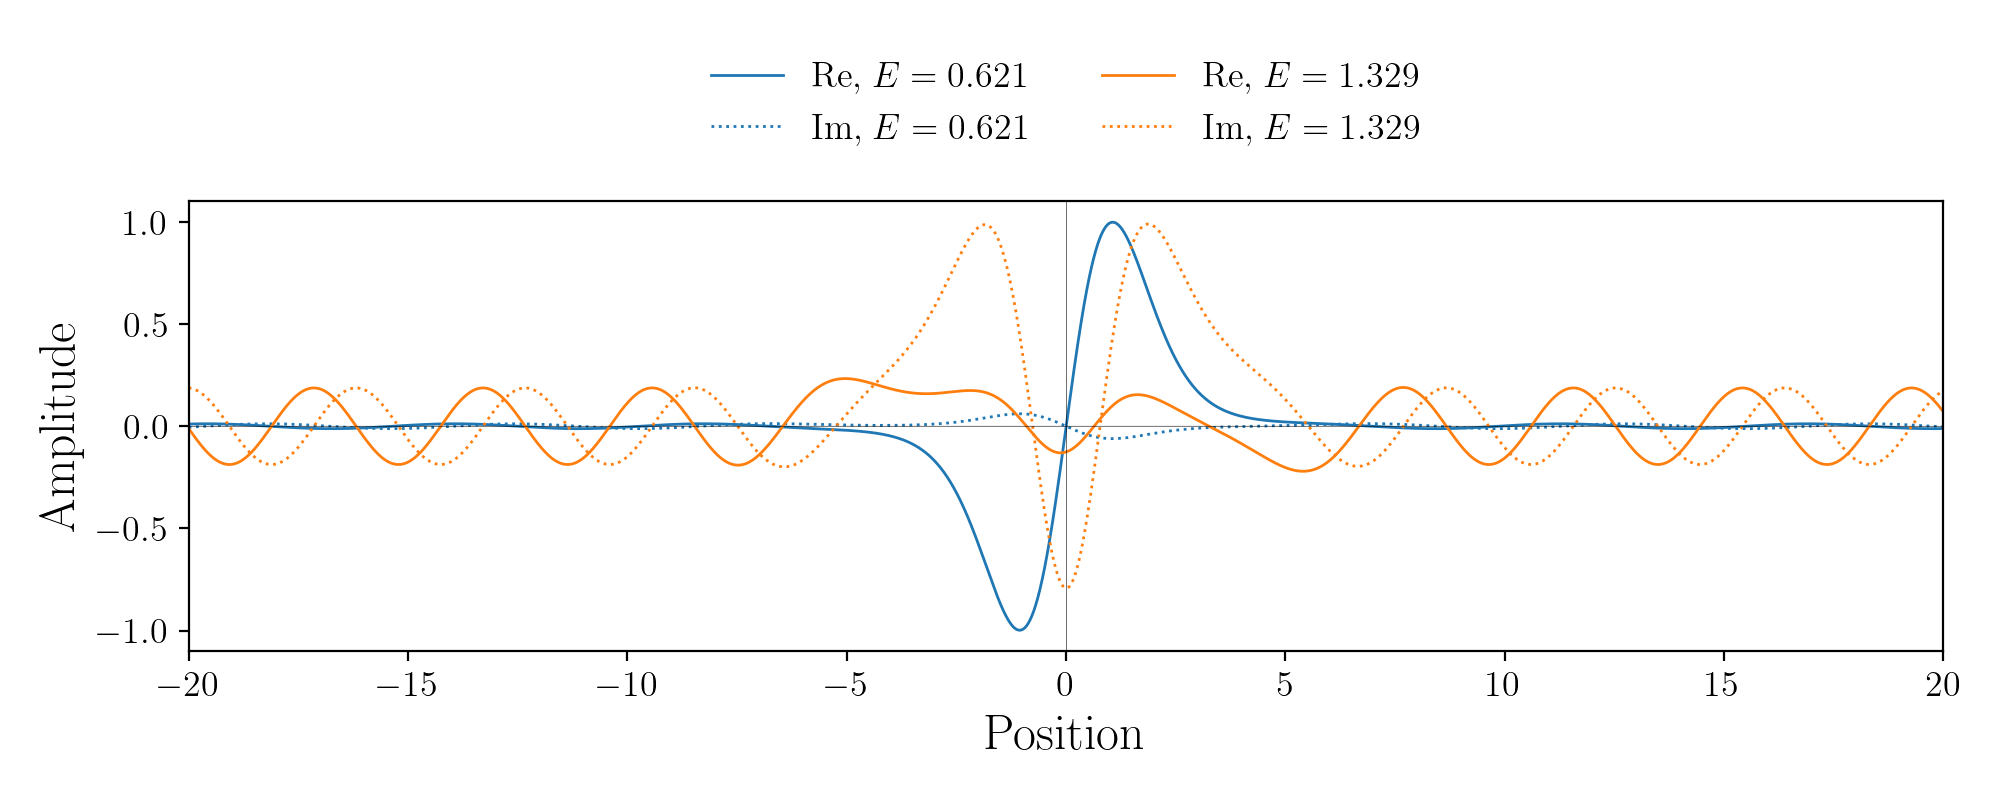

In [87]:
%matplotlib widget
#%matplotlib inline
interval = [(0.5,0.7),(1.2,1.4)]#,(1.5,2),(2.6,3.1)]
plot_slices(interval, "real")
#plot_slices(interval, "img")

In [51]:
from num2tex import num2tex
from num2tex import configure as num2tex_configure
num2tex_configure(exp_format='cdot')
num2tex(1.3489e17)

num2tex configure options:
 - help_text: boolean whether this help text is displayed when configure() is called
 - exp_format: string format specification for how the power of 10 is displayed in scientific format.
     - also accepts specifiers 'times', which is converted to '\times 10^{}', 'cdot': '\cdot 10^{}', and 'parentheses': '(10^{})'
 - display_singleton: boolean on whether the "1 \times" is printed in "1 \times 10^{p}"
          


num2tex(num=1.3489e+17)

[ 81743  81759 174431 ... 229720 229721 229722]
0.00011960029900082159 0.6211500528751323 0.6210304525761314


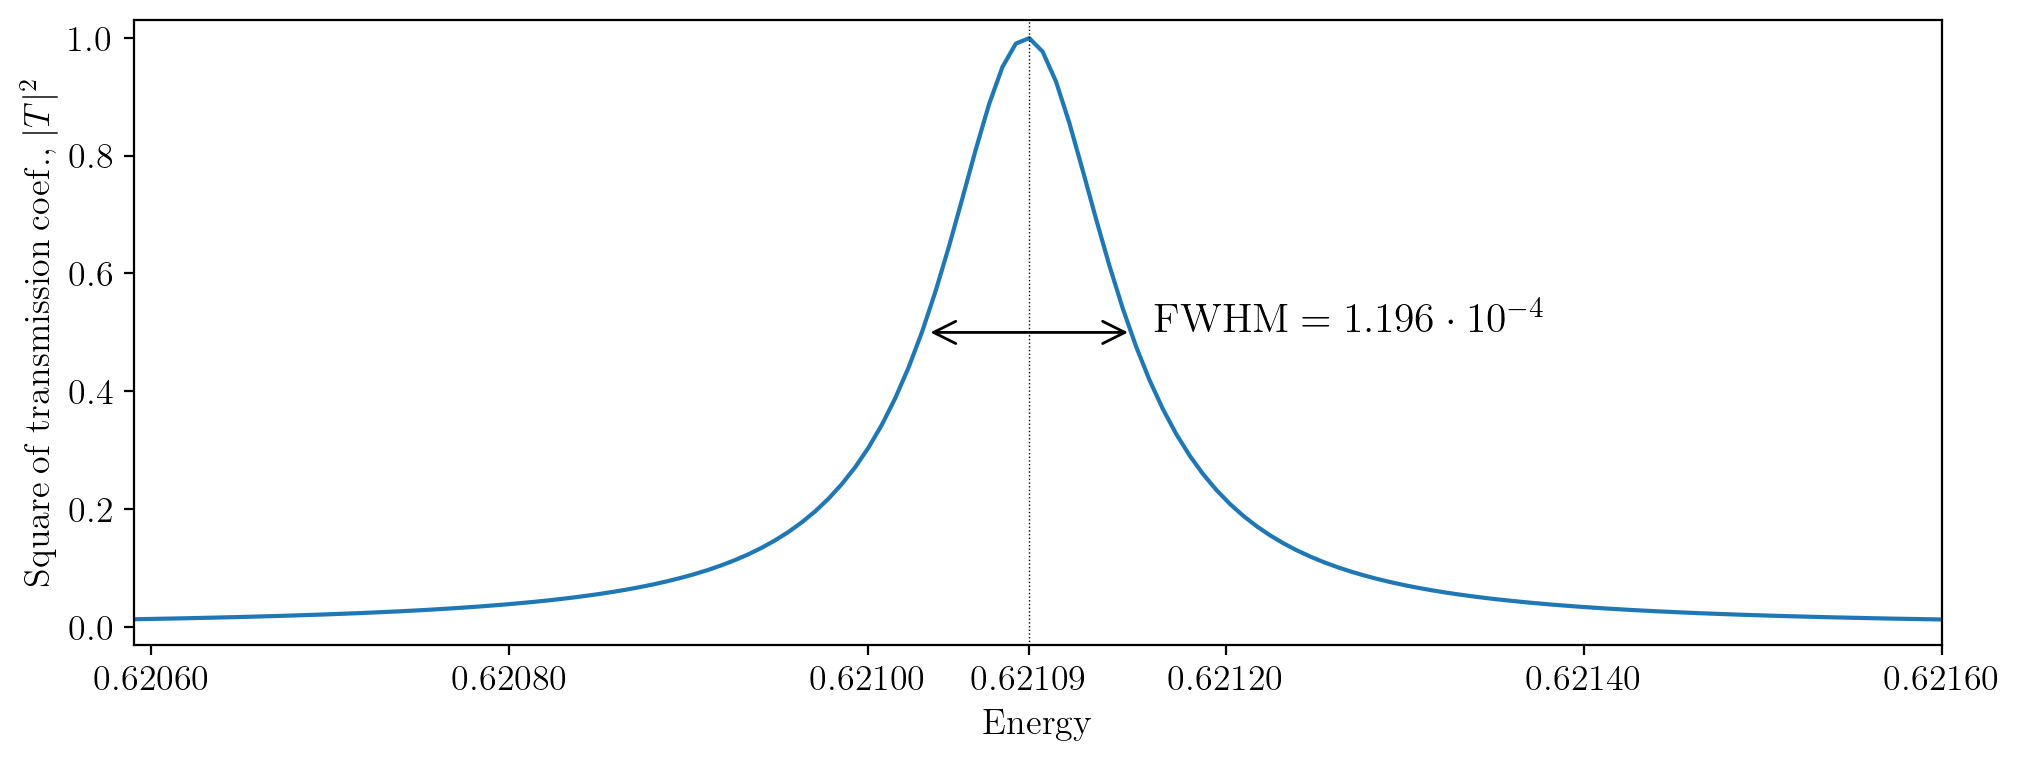

In [63]:
from matplotlib import rc
from matplotlib import gridspec
from num2tex import num2tex
from matplotlib.patches import ConnectionPatch

xp = np
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

engg = 0.6210902527256319

fig,ax = plt.subplots(figsize=(10,4),dpi=200)
plt.ylim(-0.03,1.03)
plt.xlim(engg-0.0005,engg+0.0005)
plt.xlabel("$\mathrm{Energy}$")
plt.ylabel("$\mathrm{Square\ of\ transmission\ coef.,}\ |T|^2$")
E = ee

imp = np.nonzero(np.where((np.abs(T)**2 > 0.47) & (np.abs(T)**2 < 0.53), T, 0))[0]
print(imp)
fwhm = E[imp[1]]-E[imp[0]]
print(fwhm, E[imp[1]], E[imp[0]])

plt.annotate(r"$\textrm{FWHM}="+r"{:.3e}$".format(num2tex(fwhm)),xy=(0.62116,0.5),fontsize=15)

coordsA = "data"
coordsB = "data"
con = ConnectionPatch((E[imp[1]],0.5),(E[imp[0]],0.5), coordsA, coordsB,
                      arrowstyle="<->", shrinkA=3, shrinkB=3,
                      mutation_scale=20, fc="w")
ax.add_artist(con)


plt.tight_layout()
plt.xticks([0.6206, 0.6208, 0.6210, 0.62109, 0.6212, 0.6214, 0.6216])
plt.plot(E, np.abs(T)**2)
plt.plot([engg]*2, [-2, 2], linewidth=0.5, color='k', linestyle='dotted')
plt.savefig("C:/Users/micha/Desktop/FWHM.png")

In [28]:
imp = np.nonzero(np.where((np.abs(T)**2 > 0.47) & (np.abs(T)**2 < 0.53), T, 0))[0]
print(imp)
E[imp[1]]-E[imp[0]]

[ 81743  81759 174431 ... 229720 229721 229722]


0.00011960029900082159

In [100]:
def draw_arrow(x,y,dx,dy,linedict=dict(), headdict=dict()):
    #from matplotlib import pyplot as plt
    linedict.update({'head_width': 0, 'head_length': 0})
    
    plt.arrow(x,y,dx,dy,**linedict)
    
    lnx = abs(dx)/100
    lny = abs(dy)/100
    normdx = dx/abs(dx) if dx != 0 else 0
    normdy = dy/abs(dy) if dy != 0 else 0
    plt.arrow(x+dx-normdx*lnx, y+dy-normdy*lny, lnx, lny, **headdict)

In [ ]:
draw_arrow()

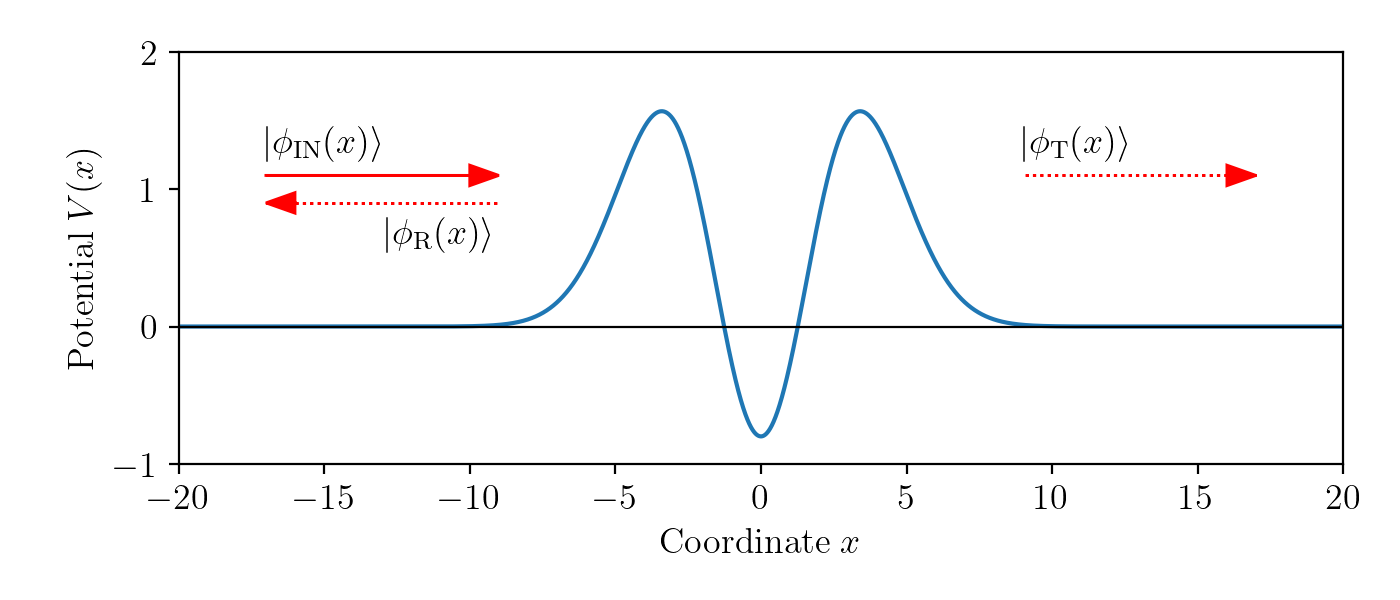

In [117]:
from matplotlib import rc
from matplotlib import gridspec

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

plt.figure(figsize=(7,3),dpi=200)
plt.ylim(-1,2)
plt.xlim(-20,20)
plt.xlabel("$\mathrm{Coordinate}\ x$")
plt.ylabel("$\mathrm{Potential}\ V(x)$")
plt.tight_layout()
plt.plot(x, potential(x))
plt.plot([-20,20],[0,0],color='k',linewidth=0.8)

plt.arrow(-17, 1.1, 8, 0, head_width=0.15,head_length=1,color='r',length_includes_head=True)
plt.arrow(-9, 0.9, -8, 0, head_width=0.0,head_length=0,color='r',linestyle='dotted',length_includes_head=True)
plt.arrow(-15.99, 0.9, -0.01, 0, head_width=0.15,head_length=1,color='r',linestyle='solid')

plt.arrow(9, 1.1, 8, 0, head_width=0.0,head_length=0,color='r',linestyle='dotted',length_includes_head=True)
plt.arrow(15.99, 1.1, 0.01, 0, head_width=0.15,head_length=1,color='r',linestyle='solid')

plt.text(-17,1.2,"$\ket{\phi_\mathrm{IN}(x)}$",ha='left',va='bottom',usetex=True)
plt.text(-9,0.8,"$\ket{\phi_\mathrm{R}(x)}$",ha='right',va='top',usetex=True)
plt.text(9,1.2,"$\ket{\phi_\mathrm{T}(x)}$",ha='left',va='bottom',usetex=True)

plt.show()

In [68]:
potential(x)

array([[8.46272168e-16, 1.24864503e-15, 1.83855641e-15, ...,
        2.66044920e-15, 1.81039170e-15, 1.22941622e-15],
       [8.46272168e-16, 1.24864503e-15, 1.83855641e-15, ...,
        2.66044920e-15, 1.81039170e-15, 1.22941622e-15],
       [8.46272168e-16, 1.24864503e-15, 1.83855641e-15, ...,
        2.66044920e-15, 1.81039170e-15, 1.22941622e-15],
       ...,
       [8.46272168e-16, 1.24864503e-15, 1.83855641e-15, ...,
        2.66044920e-15, 1.81039170e-15, 1.22941622e-15],
       [8.46272168e-16, 1.24864503e-15, 1.83855641e-15, ...,
        2.66044920e-15, 1.81039170e-15, 1.22941622e-15],
       [8.46272168e-16, 1.24864503e-15, 1.83855641e-15, ...,
        2.66044920e-15, 1.81039170e-15, 1.22941622e-15]])

In [20]:
# Nx = 10 000
# Neng = 400 000
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size': 13})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{mhchem, physics} \usepackage[utf8]{inputenc} \usepackage{textcomp}' )

plt.figure(figsize=(10,4),dpi=200)
plt.ylim(-0.03,1.03)
plt.xlim(0,3)
plt.plot(E, np.abs(T)**2)
#plt.plot(E, np.imag(T), label="$\mathrm{imaginary\ part,\ Im}[T]$")
#plt.plot([0,3],[0,0],linewidth=0.5, color='k')

plt.xlabel("$\mathrm{Energy}\ E$")
plt.ylabel("$\mathrm{Square\ of\ transmission\ coef.,}\ |T|^2$")

#plt.legend(loc='lower center', prop={'size': 13}, frameon=False, bbox_to_anchor=(0.5, 1.05),ncol=2)
plt.tight_layout()

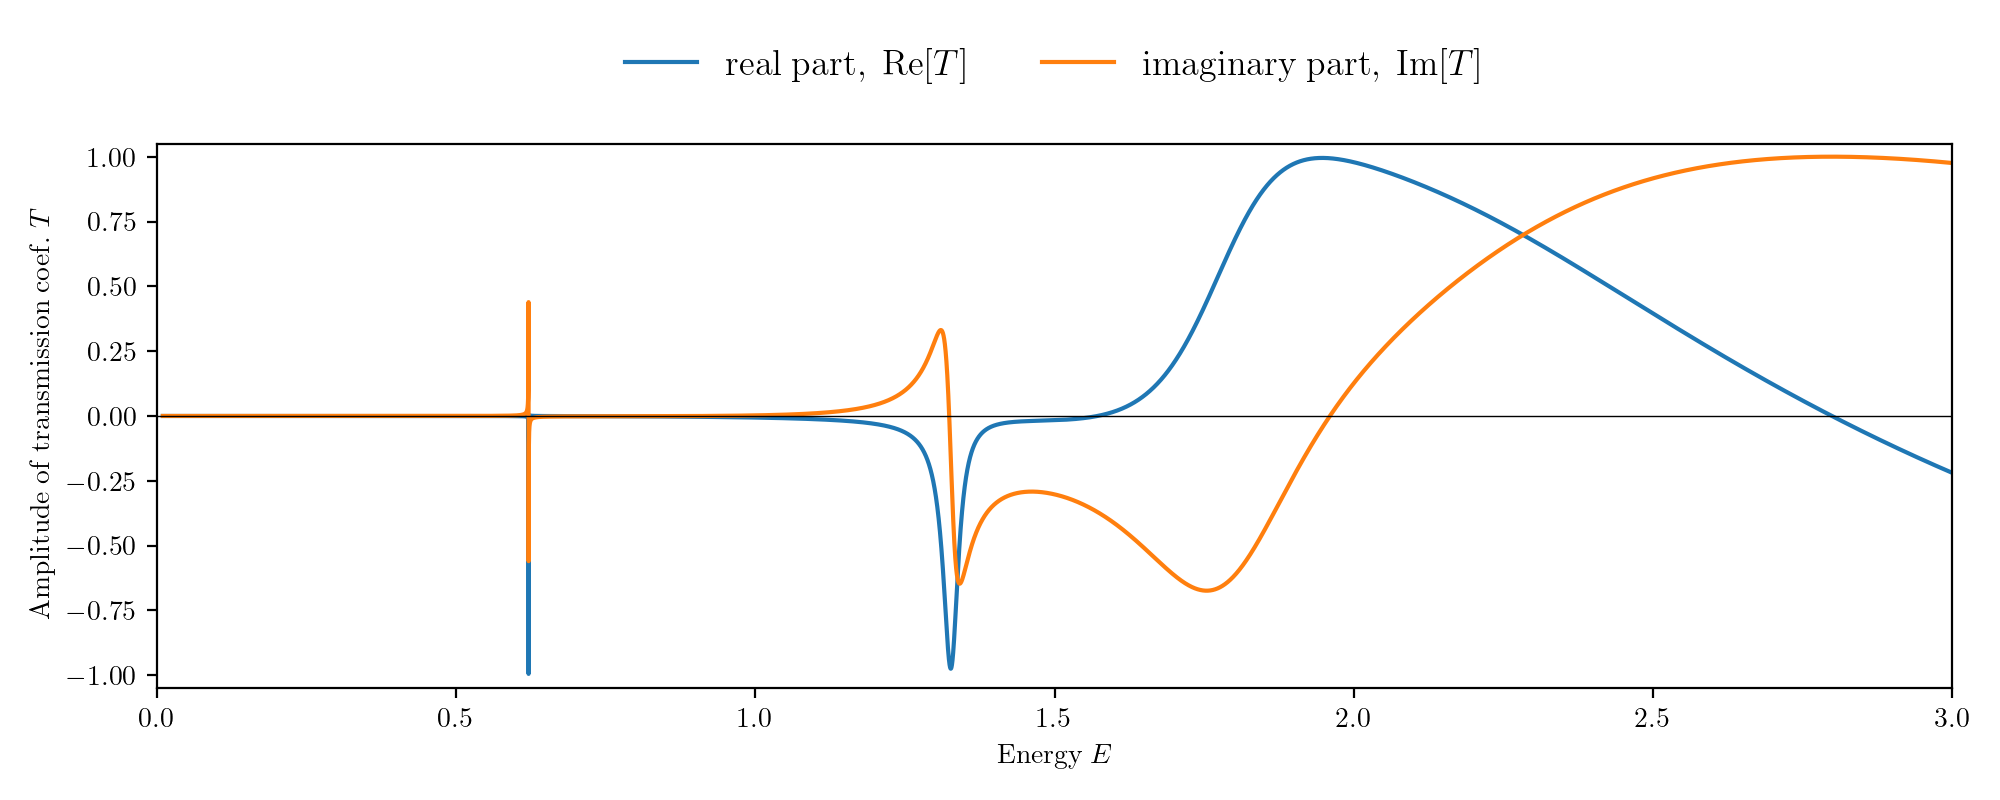

In [19]:
# Nx = 10 000
# Neng = 400 000

plt.figure(figsize=(10,4),dpi=200)
plt.ylim(-1.05,1.05)
plt.xlim(0,3)
plt.plot(E, np.real(T), label="$\mathrm{real\ part,\ Re}[ T ]$")
plt.plot(E, np.imag(T), label="$\mathrm{imaginary\ part,\ Im}[T]$")
plt.plot([0,3],[0,0],linewidth=0.5, color='k')

plt.xlabel("$\mathrm{Energy}\ E$")
plt.ylabel("$\mathrm{Amplitude\ of\ transmission\ coef.}\ T$")

plt.legend(loc='lower center', prop={'size': 13}, frameon=False, bbox_to_anchor=(0.5, 1.05),ncol=2)
plt.tight_layout()

## Save or load data

In [55]:
with open("data1.txt", "w") as file:
    for i, e in enumerate(E):
        file.write("{};{};{}\n".format(e, T[i], R[i]))

In [25]:
ee = list()
tt = list()
rr = list()

with open("data1.txt", "r") as file:
    for line in file:
        sp = line.split(";")

        ee.append(float(sp[0]))
        tt.append(complex(sp[1]))
        rr.append(complex(sp[2]))


ee = xp.array(ee)
rr = xp.array(rr)
tt = xp.array(tt)

In [26]:
T = tt

In [18]:
ae = ( np.exp(k(E) * dx * 1j) * psi01 - psi00 ) / ( np.exp(k(E) * dx * 1j) - np.exp( - k(E) * dx * 1j)) * np.exp(-k(E) * x[1] * 1j)
be = - ( np.exp(- k(E) * dx * 1j) * psi01 - psi00 ) / ( np.exp(k(E) * dx * 1j) - np.exp( - k(E) * dx * 1j)) * np.exp(k(E) * x[1] * 1j)
te = 1.0 / ae
re = te * be
np.abs(re)**2 + np.abs(te)**2

array([  1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.  

In [24]:
xp = np

## Save plotting data

In [11]:
direct = "./plotting_data1/"

In [158]:
xp.save(direct+"zdata1.data", zdata)
xp.save(direct+"ydata1.data", ydata)
xp.save(direct+"xdata1.data", pos)

In [12]:
zdata = xp.load(direct+"zdata1.data.npy")
ydata = xp.load(direct+"ydata1.data.npy")
pos = xp.load(direct+"xdata1.data.npy")

In [18]:
E = xp.load("./dat_2/"+"energies.data.npy")

## Mayavi

In [2]:
from mayavi import mlab
import numpy as np

In [3]:
%gui qt

In [53]:
mlab.clf()
x, y = np.mgrid[-10:10:100j, -10:10:100j]
r = np.sqrt(x**2 + y**2)
z = np.sin(r)/r
mlab.surf(z, warp_scale='auto')

In [ ]:
x.shape, y.shape, z.shape

In [39]:
xxx.shape, yyy.shape, zzz.shape

((4002, 400), (4002, 400), (4002, 400))

In [7]:
%gui qt
mlab.clf()
#srf = mlab.surf(zX_img.T, extent=[-20,20,0,30,-2,2])
srf = mlab.surf(zX_real.T, extent=[-20,20,0,30,-2,2])
#srf = mlab.surf(zzz.T, extent=[-20,20,0,30,-2,2])
sax = mlab.axes(srf, z_axis_visibility=False, extent=[-20,20,0,30,-1,1], ranges=[-20,20,0,3,-1,1])
mlab.colorbar(orientation='vertical')
mlab.xlabel("Position")
mlab.ylabel("Energy")
#srf.actor.actor.scale = (0.1,0.01,1)


In [8]:
import numpy as np
from mayavi.mlab import *

def test_surf():
    """Test surf on regularly spaced co-ordinates like MayaVi."""
    def f(x, y):
        sin, cos = np.sin, np.cos
        return sin(x + y) + sin(2 * x - y) + cos(3 * x + 4 * y)

    x, y = np.mgrid[-7.:7.05:0.1, -5.:5.05:0.05]
    s = surf(x, y, f)
    #cs = contour_surf(x, y, f, contour_z=0)
    return s

In [9]:
%gui qt
test_surf()

In [3]:
import numpy as np
from mayavi.mlab import *

def test_contour3d():
    x, y, z = np.ogrid[-5:5:64j, -5:5:64j, -5:5:64j]

    scalars = x * x * 0.5 + y * y + z * z * 2.0

    obj = contour3d(scalars, contours=4, transparent=True)
    return obj

test_contour3d()

In [31]:
dr = "./mayavi_plot/"
np.save(dr+"xxx",xxx)
np.save(dr+"yyy",yyy)
np.save(dr+"zzz",zX[1:])

In [32]:
np.save(dr+"zX_imag", zX[1:])

In [5]:
dr = "./mayavi_plot/"
zX_img = np.load(dr+"zX_imag.npy")
zX_real = np.load(dr+"zzz.npy")

In [6]:
dr = "./mayavi_plot/"
xxx = np.load(dr+"xxx.npy")
yyy = np.load(dr+"yyy.npy")
zzz = np.load(dr+"zzz.npy")

In [9]:
zX_real.shape

(4002, 400)